# DNA Enhancer Data Analysis

This code takes data provided by Tsarsky et al. and analyzes the effect that the number of enhancers associated with a gene has on it's transcription rate under shear stress.

***

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pybedtools import BedTool

**Filepaths**

In [ ]:
directory = 'PATH TO DATA DIRECTORY'

# The original datasets from Tsarsky et al.
file_path_seq = directory + 'GSE198221_HUVEC_RNA-Seq.csv'
file_path_enhancer = directory + '/GSE198221_Flow_Gained_ChIP_peaks.txt'

# Mapped Gene Data 
file_path_sorted_genes = directory + 'sorted_genes.bed'
file_path_mapped_genes = directory + 'enhancer_gene_mapping.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Open our dataset**

In [ ]:
# Load data
seqdf = pd.read_csv(file_path_seq)
print(seqdf.head())

   Row.names       Unnamed: 1     baseMean  log2FoldChangeFlowvsControl  \
0          1  ENSG00000000003   765.722955                    -0.674066   
1       6496  ENSG00000131386   207.253230                    -3.899804   
2       5138  ENSG00000120738    92.827228                    -3.894683   
3      10209  ENSG00000157404   311.078297                    -3.870187   
4      11744  ENSG00000165507  2868.570624                    -3.839971   

      lfcSE       stat        pvalue          padj gene_name  rpkm_Flow1  \
0  0.285058  -2.364664  1.804642e-02  1.617142e-01    TSPAN6   17.922630   
1  0.397440  -9.812315  9.970000e-23  3.960000e-20   GALNT15    0.167354   
2  0.433743  -8.979236  2.730000e-19  7.440000e-17      EGR1    0.100903   
3  0.339347 -11.404809  3.960000e-30  2.590000e-27       KIT    0.626095   
4  0.324624 -11.828999  2.760000e-32  2.590000e-29  C10orf10   10.876846   

   rpkm_Flow2  rpkm_Control1  rpkm_Control2  
0   20.542843      39.052625      24.961317  


**Filter out only the significant Genes**

In [6]:
# Filter genes with significant differential expression
significant_genes = seqdf[seqdf['pvalue'] < 0.05]

**Select for Genes which are known to be affected by shear stress**

In [7]:
shear_genes = ["KLF2", "NOS3", "VCAM1"]
known_shear_genes = seqdf[seqdf["gene_name"].isin(shear_genes)]
print(known_shear_genes)

       Row.names       Unnamed: 1     baseMean  log2FoldChangeFlowvsControl  \
4581       10923  ENSG00000162692    39.707536                    -0.254356   
26711      11588  ENSG00000164867  5253.508840                     3.483842   
26729       5980  ENSG00000127528   906.823341                     4.940662   

          lfcSE       stat        pvalue          padj gene_name  rpkm_Flow1  \
4581   0.395294  -0.643460  5.199255e-01  9.217168e-01     VCAM1    0.663033   
26711  0.239506  14.545962  6.200000e-48  1.350000e-44      NOS3  159.016881   
26729  0.309988  15.938258  3.440000e-57  2.250000e-53      KLF2   72.646747   

       rpkm_Flow2  rpkm_Control1  rpkm_Control2  
4581     0.018735       1.802605       0.123091  
26711  166.405394      12.129432      12.992223  
26729  102.041287       2.425125       1.383625  


**Identify Upregulated Genes**

In [8]:
# Upregulated genes
upregulated = significant_genes[significant_genes["log2FoldChangeFlowvsControl"] > 0]

# Downregulated genes
downregulated = significant_genes[significant_genes["log2FoldChangeFlowvsControl"] < 0]

print(f"Upregulated: {len(upregulated)} genes")
print(f"Downregulated: {len(downregulated)} genes")

Upregulated: 1242 genes
Downregulated: 864 genes


**Volcano Plot**
(thusfar we are just reproducing the results of the paper)

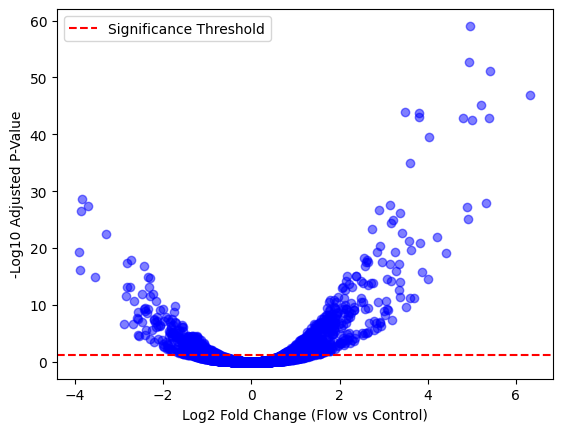

In [ ]:
plt.scatter(
    seqdf["log2FoldChangeFlowvsControl"],
    -np.log10(seqdf["padj"]),
    c="blue",
    alpha=0.5
)
plt.axhline(y=-np.log10(0.05), color="red", linestyle="--", label="Significance Threshold")
plt.xlabel("Log2 Fold Change (Flow vs Control)")
plt.ylabel("-Log10 Adjusted P-Value")
plt.title("Volcano Plot")
plt.legend()
plt.show()

**Boxplot**

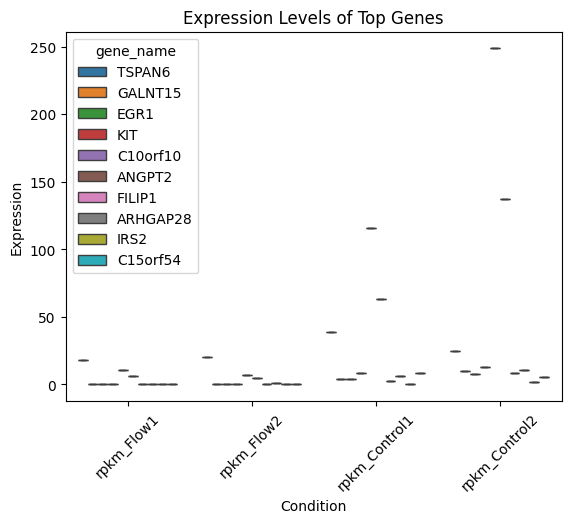

In [ ]:
top_genes = significant_genes.head(10)  # Top 10 significant genes
melted = top_genes.melt(
    id_vars=["gene_name"],
    value_vars=["rpkm_Flow1", "rpkm_Flow2", "rpkm_Control1", "rpkm_Control2"],
    var_name="Condition",
    value_name="Expression"
)

sns.boxplot(x="Condition", y="Expression", hue="gene_name", data=melted)
plt.xticks(rotation=45)
plt.title("Expression Levels of Top Genes")
plt.show()

Now we will proceed with our novel analysis. As suggeted by the paper, we will look at various enhancers.

In [ ]:
enhancerdf = pd.read_csv(file_path_enhancer, sep="\t",header=None, names= ["chr", "start", "end"])

# Preview data
print(enhancerdf.head())

     chr      start        end
0   chr1  161164851  161174260
1  chr15   75334196   75342577
2  chr12  125135244  125142294
3   chr9  130543397  130549782
4  chr10  123870718  123874711


Now we will map the enhancers

In [ ]:
# Load enhancer data
enhancers = BedTool.from_dataframe(enhancerdf.sort_values(by=['chr','start']))  # Enhancer BED file

# Load gene annotations
genes = BedTool(file_path_sorted_genes)  # Preprocessed gene annotation file

# Map enhancers to nearest genes
mapped = enhancers.closest(genes, d=True)

# Convert the mapping to a DataFrame
mapped_df = mapped.to_dataframe(names=['chr', 'start', 'end', 'gene_name', 'distance'])

# Save to a CSV
mapped_df.to_csv(file_path_mapped_genes, index=False)

In [ ]:
# Load enhancer-gene mapping
mappedenhancers_df = pd.read_csv(file_path_mapped_genes)

# Check results
print(mappedenhancers_df.head())

    chr    start      end gene_name  distance
0  chr1  1167104  1167198   MIR200B         0
1  chr1  1167863  1167952   MIR200A         0
2  chr1  1173880  1197936    TTLL10         0
3  chr1  1242446  1246722  C1QTNF12       666
4  chr1  1253909  1273864    UBE2J2         0


Merge our dataframes

In [15]:
merged_data = pd.merge(seqdf, mappedenhancers_df, on="gene_name")
print(merged_data.head())

   Row.names       Unnamed: 1     baseMean  log2FoldChangeFlowvsControl  \
0      13207  ENSG00000171408   357.685546                    -2.823238   
1      13207  ENSG00000171408   357.685546                    -2.823238   
2       9577  ENSG00000151967    66.834909                    -2.589054   
3      17523  ENSG00000196628  3513.802033                    -2.296662   
4      17523  ENSG00000196628  3513.802033                    -2.296662   

      lfcSE      stat        pvalue          padj gene_name  rpkm_Flow1  \
0  0.346821 -8.140343  3.940000e-16  7.480000e-14     PDE7B    1.664154   
1  0.346821 -8.140343  3.940000e-16  7.480000e-14     PDE7B    1.664154   
2  0.407914 -6.347065  2.190000e-10  1.970000e-08    SCHIP1    0.151862   
3  0.298330 -7.698402  1.380000e-14  2.310000e-12      TCF4    5.669408   
4  0.298330 -7.698402  1.380000e-14  2.310000e-12      TCF4    5.669408   

   rpkm_Flow2  rpkm_Control1  rpkm_Control2    chr      start        end  \
0    0.694906       9.

Count enhancers per gene

In [16]:
enhancer_counts = mappedenhancers_df.groupby("gene_name").size().reset_index(name="EnhancerCount")
merged_data = pd.merge(seqdf, enhancer_counts, on="gene_name", how="left")

Compare experession-based enhancer count

In [17]:
single_enhancer = merged_data[merged_data["EnhancerCount"] == 1]
multiple_enhancers = merged_data[merged_data["EnhancerCount"] > 1]

print(f"Single Enhancer Genes: {len(single_enhancer)}")
print(f"Multiple Enhancer Genes: {len(multiple_enhancers)}")

Single Enhancer Genes: 1029
Multiple Enhancer Genes: 675


Test if genes with multiple enhancers are more upregulated than those with single enhancers

In [21]:
from scipy.stats import ttest_ind

# Log2 fold change comparison
single_lfc = single_enhancer["log2FoldChangeFlowvsControl"].dropna()
multiple_lfc = multiple_enhancers["log2FoldChangeFlowvsControl"].dropna()


# Perform t-test
t_stat, p_value = ttest_ind(single_lfc, multiple_lfc)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -1.7645436635731835, P-value: 0.07785484201923847


Create a boxplot

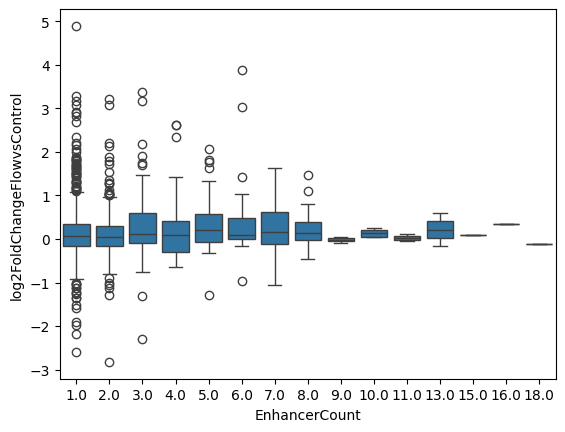

In [ ]:
sns.boxplot(
    data=merged_data,
    x="EnhancerCount",  # Create this column: "Single" or "Multiple"
    y="log2FoldChangeFlowvsControl"
)
#plt.title("Log2 Fold Change by Enhancer Count")
plt.show()


And a heatmap

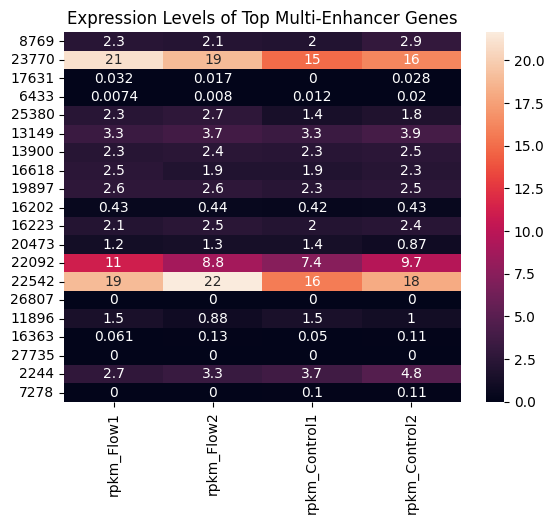

In [ ]:
top_genes = multiple_enhancers.nlargest(20, "EnhancerCount")
sns.heatmap(top_genes[["rpkm_Flow1", "rpkm_Flow2", "rpkm_Control1", "rpkm_Control2"]], annot=True)
plt.title("Expression Levels of Top Multi-Enhancer Genes")
plt.show()

In [24]:
from scipy.stats import bartlett

# Perform Bartlett’s test
stat, p_value = bartlett(single_lfc, multiple_lfc)
print(f"Bartlett's Test Statistic: {stat}, P-value: {p_value}")

Bartlett's Test Statistic: 1.5099387706448504, P-value: 0.21914842966609577


In [25]:
# Calculate variances
variance_single = single_lfc.var()
variance_multiple = multiple_lfc.var()

print(f"Variance (Single Enhancers): {variance_single}")
print(f"Variance (Multiple Enhancers): {variance_multiple}")

Variance (Single Enhancers): 0.38782418616882375
Variance (Multiple Enhancers): 0.42581857056266975


Step 7: Interpret Results
If genes with multiple enhancers show higher fold changes, it supports synergistic enhancer activity under shear stress.
Identify specific pathways or gene families enriched among the multi-enhancer genes for biological insights.